## Import

In [4]:
import os
import re
import json
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import scipy.spatial

## Dataset & Embedding

In [ ]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('Chaeyeon/SBERT-added-patent-vocab')
model = AutoModel.from_pretrained('Chaeyeon/SBERT-added-patent-vocab')

In [ ]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('zzzzzioni/added-patent-word-recog-tokenizer')
model = AutoModel.from_pretrained('zzzzzioni/added-patent-tokens-KR-SBERT-V40K-klueNLI-augSTS')

In [9]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'Using device: {device}')

Using device: cuda


In [6]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [7]:
def check_if_processed(file_path):
    """파일이 이미 '_new.csv'로 끝나는지 확인하여 처리된 파일인지 검사합니다."""
    return file_path.endswith('_new.csv')

In [8]:
def embed_cleaned_summary(df, model, tokenizer):
    embeddings = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Embedding rows"):
        text = str(row['cleaned_summary']).strip().lower()
        if text and text not in ['none', '요약 없음', 'null']:
            encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512).to(device)
            with torch.no_grad():
                model_output = model(**encoded_input)
            sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
            # Convert the embedding to a list and append it to the embeddings list
            embeddings.append(sentence_embedding.squeeze().tolist())
        else:
            embeddings.append(None)  # You may choose to handle None differently

    # Instead of trying to assign a 2D array directly, assign a list of embeddings
    df['embeddings'] = embeddings
    return df

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kpmg/processed_kr_patent_C/C01C_KR_with_embeddings_new.csv')

In [60]:
if not isinstance(df['IPC_code_only'][0], list):
    df['IPC_code_only'] = df['IPC_code_only'].apply(lambda x: [x])
df['IPC_code_only']

0              [['C01C', 'B01D', 'B01D', 'B01D']]
1                      [['C01C', 'B01D', 'B01D']]
2              [['B01D', 'C01C', 'C01C', 'B05B']]
3      [['C01B', 'C01B', 'C01C', 'C01C', 'F01N']]
4              [['B01D', 'C01C', 'C01C', 'B05B']]
                          ...                    
495                    [['C01C', 'C07C', 'C07C']]
496                                    [['C01C']]
497                                    [['C01C']]
498            [['C07C', 'C07D', 'C07C', 'C01C']]
499                                    [['C01C']]
Name: IPC_code_only, Length: 500, dtype: object

## Clustering with new model

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [12]:
df = pd.read_csv('/content/drive/MyDrive/kpmg/cluster_dataset.csv')

In [ ]:
# 임베딩된 데이터프레임 생성
df = embed_cleaned_summary(df, model, tokenizer)

In [14]:
df['Subclass'] = df['Category']
df['Class'] = df['Category'].apply(lambda x: x[0])

In [16]:
df['embeddings'].head()

0    [-0.7614201307296753, -0.7914007306098938, -0....
1    [-0.3166218101978302, -1.0444456338882446, -0....
2    [0.3761041760444641, -0.5116180181503296, -0.7...
3    [-0.5034749507904053, -0.7243849039077759, -0....
4    [-0.8238877058029175, -0.4026890695095062, -0....
Name: new_embeddings, dtype: object

In [17]:
embeddings = np.array(df['embeddings'].tolist())

In [18]:
tsne = TSNE(n_components=2, verbose=1, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.003s...
[t-SNE] Computed neighbors for 4000 samples in 0.335s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 3.030798
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.108170
[t-SNE] KL divergence after 1000 iterations: 2.068723


In [141]:
palette = sns.cubehelix_palette(start=8, n_colors=len(df['Class'].unique()))

In [19]:
# KMeans 클러스터링
n_clusters=7
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
df['cluster_label'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


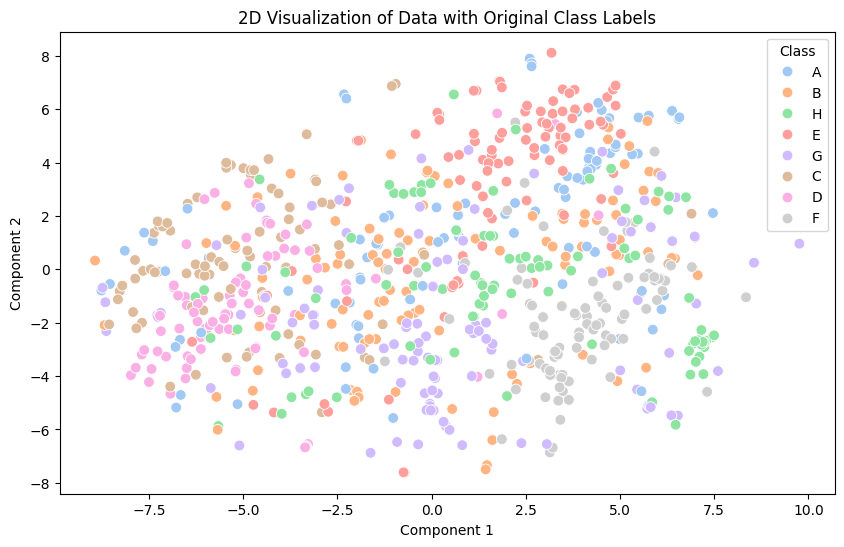

In [102]:
# # 소규모 데이터 try

# palette = sns.color_palette("pastel", len(df['Class'].unique()))

# # t-SNE 결과를 시각화하고, 각 점을 'Class' 라벨에 따라 색상을 지정
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=df['Class'], palette=palette, s=60)
# plt.title('2D Visualization of Data with Original Class Labels')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.legend(title='Class')
# plt.show()

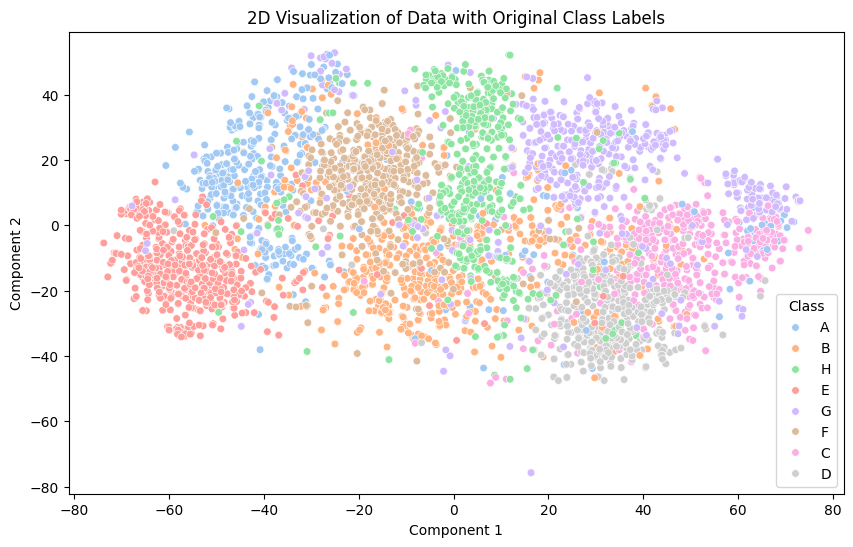

In [21]:
# 고유 라벨 'Class'를 기준으로 색상 지정
palette = sns.color_palette("pastel", len(df['Class'].unique()))

# t-SNE 결과를 시각화하고, 각 점을 'Class' 라벨에 따라 색상을 지정
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=df['Class'], palette=palette, s=30)
plt.title('2D Visualization of Data with Original Class Labels')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Class')
plt.show()

In [136]:
embeddings = np.array(df['embeddings'].tolist())

tsne = TSNE(n_components=2, verbose=1, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.003s...
[t-SNE] Computed neighbors for 4000 samples in 0.271s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 2.820010
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.953613
[t-SNE] KL divergence after 1000 iterations: 1.891387


In [137]:
# KMeans 클러스터링
n_clusters=7
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
df['cluster_label'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


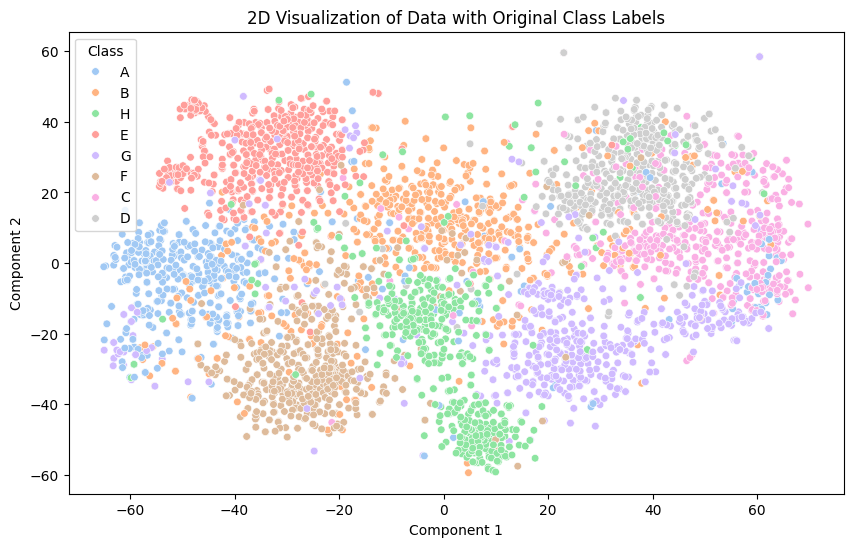

In [138]:
# 고유 라벨 'Class'를 기준으로 색상 지정
palette = sns.color_palette("pastel", len(df['Class'].unique()))

# t-SNE 결과를 시각화하고, 각 점을 'Class' 라벨에 따라 색상을 지정
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=df['Class'], palette=palette, s=30)

plt.title('2D Visualization of Data with Original Class Labels')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Class')
plt.show()